In [1]:
import pandas as pd
import numpy as np
from scipy.fft import fft
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from scipy.signal import find_peaks

In [2]:
df = pd.read_csv('Данные по заболеванию.csv', delimiter=';')


In [10]:
df.columns

Index(['Дата', 'Заражений за день', 'Выздоровлений за день',
       'Смертей за день'],
      dtype='object')

In [12]:
#Получение данных
df['Дата'] = pd.to_datetime(df['Дата'])
df['Заражений за день']

0         34
1         11
2         14
3          4
4         28
        ... 
1033    2754
1034    3032
1035    4201
1036    4675
1037    5078
Name: Заражений за день, Length: 1038, dtype: int64

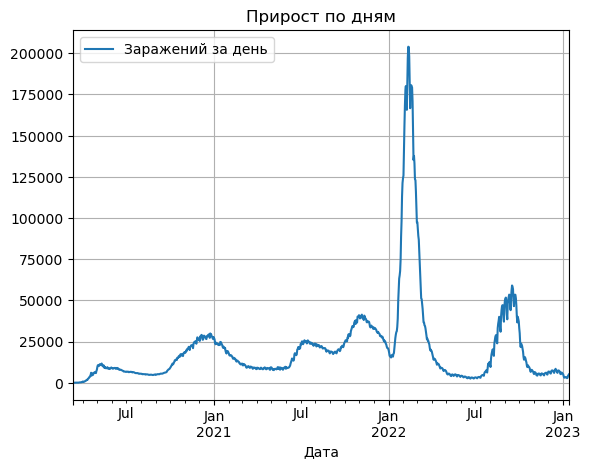

In [11]:
#Построим график
df.plot(x='Дата', y=['Заражений за день'], title='Прирост по дням')
plt.grid()
plt.show()

In [15]:
#Найдем частоту дискретизации
chast_disk = np.mean(np.diff(df['Дата'])) / np.timedelta64(1, 's')
chast_disk

86400.0

In [16]:
data_sec = [i * chast_disk for i in range(df.shape[0])]
df['Секунды'] = data_sec
freq_discr = 1/chast_disk
print ('Количество диапазонов с частотой дискретизации', round(freq_discr, 8) , 'сек -', len(df['Секунды']))

Количество диапазонов с частотой дискретизации 1.157e-05 сек - 1038


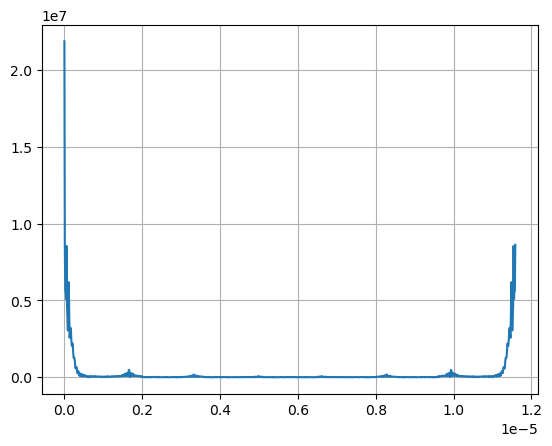

In [19]:
#Применим прямое Фурье преобразование
freq_new = [i*chast_disk for i in range (int(max(data_sec)//chast_disk))]
df_fourier = np.fft.fft(df['Заражений за день'])
fr = [i/freq_new[-1] for i in range(len(df['Заражений за день']))]
plt.plot(fr, abs(df_fourier))
plt.grid()
#Получаем спектр

In [20]:
#Выведем данные
df['Фурье'] = abs(df_fourier)
df

,Дата,Заражений за день,Выздоровлений за день,Смертей за день,Секунды,Фурье
0,2020-03-12,34,0,0,0.0,2.184672e+07
1,2020-03-13,11,0,0,86400.0,8.621454e+06
2,2020-03-14,14,0,0,172800.0,5.636214e+06
3,2020-03-15,4,3,0,259200.0,5.622244e+06
4,2020-03-16,28,2,0,345600.0,5.082211e+06
...,...,...,...,...,...,...
1033,2023-01-09,2754,2990,41,89251200.0,8.538142e+06
1034,2023-01-10,3032,5062,47,89337600.0,5.082211e+06
1035,2023-01-11,4201,5122,46,89424000.0,5.622244e+06
1036,2023-01-12,4675,4541,48,89510400.0,5.636214e+06


Покажем на спектре пики, ось y в логарифмическом масштабе, в нем лучше видны пики

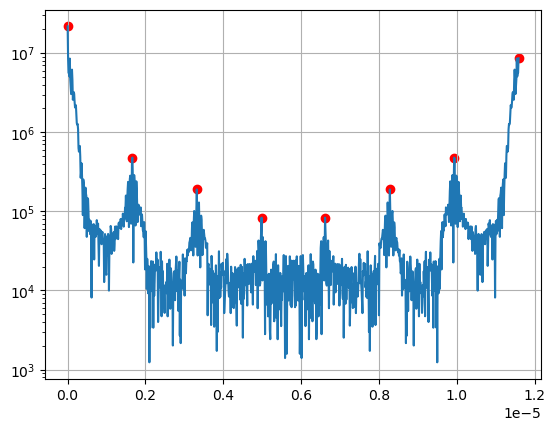

In [21]:
#Построим график спектра с выделенными пиками
n = 50
df['Локальный максимум Фурье преобразования'] = df.iloc[argrelextrema(df['Фурье'].values, np.greater_equal, order=n)[0]]['Фурье']
plt.plot(fr, abs(df_fourier))
plt.scatter(fr, df['Локальный максимум Фурье преобразования'], c='r')
plt.yscale('log')
plt.grid()

In [22]:
df['Частоты'] = fr
freq_1 = df[abs(df_fourier) == df['Локальный максимум Фурье преобразования']].copy()
freq_1.index = np.arange(len(freq_1))
freq_1

,Дата,Заражений за день,Выздоровлений за день,Смертей за день,Секунды,Фурье,Локальный максимум Фурье преобразования,Частоты
0,2020-03-12,34,0,0,0.0,2.184672e+07,2.184672e+07,0.000000
1,2020-08-08,5212,6615,129,12873600.0,4.781567e+05,4.781567e+05,0.000002
2,2021-01-03,24150,19847,504,25660800.0,1.890479e+05,1.890479e+05,0.000003
3,2021-06-01,9500,8994,372,38534400.0,8.316752e+04,8.316752e+04,0.000005
4,2021-10-25,37930,20690,1069,51148800.0,8.316752e+04,8.316752e+04,0.000007
5,2022-03-23,26826,70622,429,64022400.0,1.890479e+05,1.890479e+05,0.000008
6,2022-08-18,35809,21491,62,76809600.0,4.781567e+05,4.781567e+05,0.000010
7,2023-01-13,5078,4271,47,89596800.0,8.621454e+06,8.621454e+06,0.000012


In [23]:
l = np.array([freq_1['Частоты'][i + 1] - freq_1['Частоты'][i] for i in range(len(freq_1) - 1)])
print(np.round(1 / (l * 3600 * 24), 2))

[6.95 7.   6.95 7.1  6.95 7.   7.  ]


In [24]:
#После проведения рассчетов видно: периодичность равна 7 дням
df['data'] = df['Заражений за день']

In [25]:
df['max'] = df.iloc[argrelextrema(df.data.values, np.greater_equal, order=n)[0]]['data']

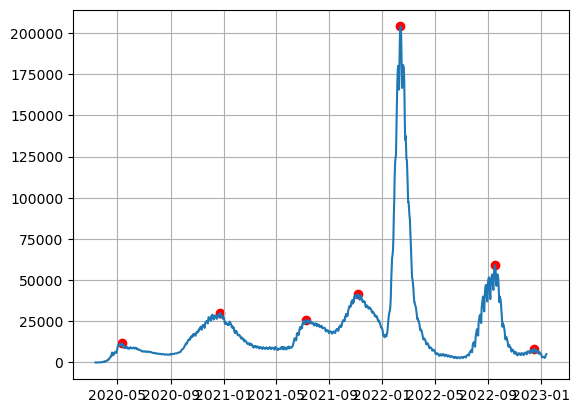

In [27]:
#Отобразим на графике пики
plt.scatter(df['Дата'], df['max'], c='r')
plt.plot(df['Дата'], df['Заражений за день'])
plt.grid()

Пики заболеваемости

In [30]:
#Вывудем пики заболеваний
df['max_NaN'] = np.where(df['max'].isnull(), 0, 1)
df = df[df['max_NaN'] != 0]
df['Дата']

60     2020-05-11
287    2020-12-24
484    2021-07-09
604    2021-11-06
701    2022-02-11
918    2022-09-16
1009   2022-12-16
Name: Дата, dtype: datetime64[ns]

В ходе домашнего задания была проведена оценка периодичности прироста заболевания короновирусом. Период новых заболеваний составил 7 дней. Данные изменения могут быть связаны с увеличением заболевших из-за наличия выходных дней во время которых можно заразить ближайших родственников или друзей.
Кроме того, были определены даты с наибольшим приростом количества заболевших. В большенстве случев это было либо осенью, либо зимой. Именно в эти сезоны иммунитет человека понижен.